### DSE-230 Final Project
## Diabetes Risk Prediction from Personal Health Indicators
### Notebook 3: Modeling and Evaluation
***
#### Chunxia Tong  
#### Camm Perera
#### Sergey Gurvich

***
## Table of Contents:

* [1. Notebook Setup](#project_description)
    * [1.1 Imports](#imports)
    * [1.2 Start Spark Session](#start_spark_session)
    * [1.3 Read Data](#read_data)
* [2. Feature Transformation](#feature_transformation)
* [3. Modeling](#modeling)
    * [3.1 Logistic Regression](#log_reg)
    * [3.2 Linear SVM](#lsvm)
    * [3.3 Decision Tree](#dtree)
    * [3.4 Gradient Boosted Tree Classifier](#gbtc)
    * [3.5 Random Forest Classifier](#rfc)
* [4. Results Evaluation](#evaluation)
    * [4.1 Selection of the Best Model](#evaluation)
    * [4.2 ROC Curves for Train and Test Data](#roc)
* [5. Stop Spark Session](#stop)
***

### 1. Notebook Setup <a class="anchor" id="setup"></a>
Please read Readme file located in https://github.com/spring-camm-sergey/dse230/blob/main/README.txt

**Prerequisite: The notebook #2 should be executed and produce the file 'df_features_transformation.csv' in HDFS root directory.**

#### 1.1 Imports <a class="anchor" id="imports"></a>

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import pyspark
# import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import StandardScaler, Normalizer, OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#### 1.2 Start Spark Session <a class="anchor" id="start_spark_session"></a>

In [2]:
conf = pyspark.SparkConf().setAll([('spark.master', 'local[*]'),
                                   ('spark.app.name', 'Basic Setup'),
                                    ('spark.memory.offHeap.enabled', True),
                                    ('spark.memory.offHeap.size','8g'),
                                    ('spark.executor.memory', '16g'), 
                                    ('spark.driver.memory','16g')
                                  ]
                                  )
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setLogLevel('OFF')
spark.version

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-31 00:12:15,068 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


'3.2.1'

#### 1.3 Read Data <a class="anchor" id="read_data"></a>
**Prerequisite: The notebook #2 should be executed and produce the file 'df_features_transformation.csv' in HDFS root directory.**

In [3]:
# main dataset
df_features_transformation = spark.read.option("header", True).csv('hdfs:///df_features_transformation.csv', inferSchema=True)

### 2. Feature Transformation <a class="anchor" id="feature_transformation"></a>

In [4]:
# do backup for using with models, that don't require one-hot encoding and scaling
df_features_transformation_backup = df_features_transformation

##### One-hot encoding

In [5]:
# df_features_transformation = df_features_transformation_backup

# columns to transform
one_hot_cols_inp = ['GENHLTH', 'EMPLOY1', 'DIFFWALK', 'RMVTETH4', 'EXERANY2', 'CHECKUP1', 'PNEUVAC4']
# transformed colums will have '_OH' suffix in the name
one_hot_cols_outp = [x+'_OH' for x in one_hot_cols_inp]

# do the transformation
encoder = OneHotEncoder(
    inputCols=one_hot_cols_inp,  
    outputCols=one_hot_cols_outp
)
model = encoder.fit(df_features_transformation)
df_features_transformation = model.transform(df_features_transformation)

# drop original columns
df_features_transformation = df_features_transformation.drop(*one_hot_cols_inp)

df_features_transformation.show(1)

+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|_AGE80|_BMI5|_MICHD|_DRDXAR2|ALCDAY5|label|   GENHLTH_OH|   EMPLOY1_OH|  DIFFWALK_OH|  RMVTETH4_OH|  EXERANY2_OH|  CHECKUP1_OH|  PNEUVAC4_OH|
+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|    56| 1660|     0|       1|      0|    1|(7,[2],[1.0])|(8,[4],[1.0])|(7,[2],[1.0])|(7,[2],[1.0])|(7,[1],[1.0])|(7,[4],[1.0])|(7,[2],[1.0])|
+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
only showing top 1 row



##### Logistic Regession and LSVM Models: Test/Training Data Splitting,  Scaling, Normalizing

In [6]:
# assemble all features in vector
col_feature_names = list(df_features_transformation.columns)
col_feature_names.remove('label')
vecAssembler = VectorAssembler(inputCols = col_feature_names, outputCol="features_unscaled")
df_features_transformation_unscaled = vecAssembler.transform(df_features_transformation)

# Generalization: split to test and train dataframes
train, test = df_features_transformation_unscaled.randomSplit([0.8, 0.2], seed=42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

# scale data
standardScaler = StandardScaler(inputCol='features_unscaled', outputCol='features_scaled', withMean=True, withStd=True)
model = standardScaler.fit(train)
scaled_train = model.transform(train)
scaled_test= model.transform(test)

# normalize data
normalizer = Normalizer(p=2.0, inputCol='features_scaled', outputCol='features')
scaled_train = normalizer.transform(scaled_train)
scaled_test= normalizer.transform(scaled_test)

scaled_train.show(1)

Training Dataset Count: 66732


Test Dataset Count: 16823


+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-----------+-------------+-------------+-----------+--------------------+--------------------+--------------------+
|_AGE80|_BMI5|_MICHD|_DRDXAR2|ALCDAY5|label|   GENHLTH_OH|   EMPLOY1_OH|  DIFFWALK_OH|RMVTETH4_OH|  EXERANY2_OH|  CHECKUP1_OH|PNEUVAC4_OH|   features_unscaled|     features_scaled|            features|
+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-----------+-------------+-------------+-----------+--------------------+--------------------+--------------------+
|    18| 1481|     0|       0|      0|    0|(7,[4],[1.0])|(8,[6],[1.0])|(7,[2],[1.0])|  (7,[],[])|(7,[2],[1.0])|(7,[1],[1.0])|  (7,[],[])|(55,[0,1,9,18,22,...|[-2.4727548953379...|[-0.2711456021676...|
+------+-----+------+--------+-------+-----+-------------+-------------+-------------+-----------+-------------+-------------+-----------+--------------------+--------------------+------------

##### Tree Based Models: Test/Training Data Splitting, Feature Indexing

In [7]:
# make backup of data for many cycles of running
df_features_transformation_backup1 = df_features_transformation_backup
data = df_features_transformation_backup1

# assemble all features in vector
col_feature_names = list(data.columns)
col_feature_names.remove('label')
vec_assembler = VectorAssembler(inputCols = col_feature_names, outputCol="features")
data = vec_assembler.transform(data)

# to recognize categorical features
feature_indexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=10)
data = feature_indexer.fit(data).transform(data)

# drop features columns
data = data.drop(*col_feature_names, 'features')

# Split the data
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

## 3. Modeling <a class="anchor" id="modeling"></a>

##### The function for models evaluation

In [8]:
def evaluate(model, predictions_df, label='', model_name=''):
    """
    The function calculates the evaluation metrics for the models.
    
    :param Model Object model: - model object after fitting the data
    :param DataFrame predictions_df - DataFrame with label and predicted values
    :param str label - the name of column with labels
    :param str model_name - name of the model for priting the title
    :return: None
    """
    #  replace 0s with 2, to get correct confusion matrix
    preds_and_labels = predictions_df.select(['prediction',label])
    preds_and_labels = preds_and_labels.withColumn("prediction",when(preds_and_labels.prediction == 0,2).otherwise(1))
    preds_and_labels = preds_and_labels.withColumn(label,when(preds_and_labels[label] == 0,2).otherwise(1))

    # cast to float
    preds_and_labels = preds_and_labels.select(['prediction',label]).withColumn(label, pyspark.sql.functions.col(label).cast(FloatType())).orderBy('prediction')
    preds_and_labels = preds_and_labels.select(['prediction',label]).withColumn('prediction', pyspark.sql.functions.col('prediction').cast(FloatType())).orderBy('prediction')

    pred_and_labels_rdd = preds_and_labels.rdd.map(tuple)
    
    metrics = MulticlassMetrics(pred_and_labels_rdd)
    metrics.confusionMatrix().toArray()
    
    print(f"Evaluation of {model_name}")
    print("accuracy:",metrics.accuracy)
    print("test error:",(1 - metrics.accuracy))
    print("precision:",metrics.precision(2))
    print("recall:",metrics.recall(2))
    print("\n confusionMatrix:\n",metrics.confusionMatrix().toArray(),'\n')
    print("fMeasure:" ,metrics.fMeasure(2.0, 1.0))


### 3.1 Logistic Regression  <a class="anchor" id="log_reg"></a>
#### Tune Decision Tree Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [9]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time

# lr_model = LogisticRegression(featuresCol ='features',labelCol='label') 

# # Sequence stages
# pipeline = Pipeline(stages=[lr_model])

# # Hyper parameter tuning
# lr_param_grid = ParamGridBuilder()\
#             .addGrid(lr_model.elasticNetParam,[0.0, 0.5, 1.0])\
#             .addGrid(lr_model.fitIntercept,[False, True])\
#             .addGrid(lr_model.maxIter,[10, 30, 50, 1000])\
#             .addGrid(lr_model.family, ['binomial']) \
#             .addGrid(lr_model.regParam, [0.0001, 0.001, 0.1, 1.0, 2.0]) \
#             .build()

# # Cross validation
# lr_cross_val = CrossValidator(estimator = pipeline,
#                          estimatorParamMaps = lr_param_grid,
#                          evaluator = BinaryClassificationEvaluator(),
#                          numFolds = 10)

# lr_fit_model = lr_cross_val.fit(scaled_train)

# # Best model params:
# best_params_idx = np.argmax(lr_fit_model.avgMetrics)
# print(f"{lr_param_grid[best_params_idx]} \nAVG Metric: {lr_fit_model.avgMetrics[best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**

{Param(parent='LogisticRegression_b52edbd3bc0f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0, Param(parent='LogisticRegression_b52edbd3bc0f', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_b52edbd3bc0f', name='maxIter', doc='max number of iterations (>= 0).'): 30, Param(parent='LogisticRegression_b52edbd3bc0f', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'binomial', Param(parent='LogisticRegression_b52edbd3bc0f', name='regParam', doc='regularization parameter (>= 0).'): 0.0001} 
AVG Metric: 0.8267837084585531

CPU times: user 26 s, sys: 15.3 s, total: 41.4 s
Wall time: 45min 47s

##### Evaluate the model with unseen data and best hyperparameters combination

In [10]:
# Cross validation
best_lr_model = LogisticRegression(featuresCol ='features'
                              ,labelCol='label',maxIter=30, regParam=0.0001, family= 'binomial'
                              ,fitIntercept=False , elasticNetParam=1.0).fit(scaled_train)

best_lr_preds_train = best_lr_model.transform(scaled_train)
best_lr_preds_test = best_lr_model.transform(scaled_test)

evaluate(best_lr_model, best_lr_preds_train, 'label', 'Logistic Regression Train Data')
evaluate(best_lr_model, best_lr_preds_test, 'label', 'Logistic Regression Test Data')

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Evaluation of Logistic Regression Train Data
accuracy: 0.7502997062878379
test error: 0.24970029371216207
precision: 0.7741671842819314
recall: 0.7082485943294653

 confusionMatrix:
 [[26388.  6908.]
 [ 9755. 23681.]] 

fMeasure: 0.7397422881686841


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Evaluation of Logistic Regression Test Data
accuracy: 0.7533139154728645
test error: 0.24668608452713547
precision: 0.7694884679809303
recall: 0.7166686667466698

 confusionMatrix:
 [[6701. 1789.]
 [2361. 5972.]] 

fMeasure: 0.7421399279234496


### 3.2 Linear SVM  <a class="anchor" id="lsvm"></a>
#### Tune Linear SVM  Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [11]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time
# lsvc_model = LinearSVC(featuresCol ='features',labelCol='label')

# # Sequence stages
# pipeline = Pipeline(stages=[lsvc_model])

# # Hyper parameter tuning
# lsvc_param_grid = ParamGridBuilder()\
#             .addGrid(lsvc_model.threshold,[0.0,0.1, 0.2])\
#             .addGrid(lsvc_model.aggregationDepth, [2,4,6])\
#             .addGrid(lsvc_model.tol,[0.001, 0.1, 1.0])\
#             .addGrid(lsvc_model.regParam, [0.0001, 0.001, 0.1, 1.0, 10.0]) \
#             .addGrid(lsvc_model.fitIntercept,[False, True])\
#             .addGrid(lsvc_model.maxIter,[100, 1000, 10000])\
#             .build()

# # Cross validation
# lsvc_cross_val = CrossValidator(estimator = pipeline,
#                          estimatorParamMaps = lsvc_param_grid,
#                          evaluator = BinaryClassificationEvaluator(),
#                          numFolds = 10)

# lsvc_fit_model = lsvc_cross_val.fit(scaled_train)

# # Best model params:
# lsvc_best_params_idx = np.argmax(lsvc_fit_model.avgMetrics)
# print(f"{lsvc_param_grid[lsvc_best_params_idx]} \nAVG Metric: {lsvc_fit_model.avgMetrics[lsvc_best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**

{Param(parent='LinearSVC_58ed1f58e665', name='threshold', doc='The threshold in binary classification applied to the linear model prediction.  This threshold can be any real number, where Inf will make all predictions 0.0 and -Inf will make all predictions 1.0.'): 0.0, Param(parent='LinearSVC_58ed1f58e665', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 6, Param(parent='LinearSVC_58ed1f58e665', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0).'): 0.001, Param(parent='LinearSVC_58ed1f58e665', name='regParam', doc='regularization parameter (>= 0).'): 0.0001, Param(parent='LinearSVC_58ed1f58e665', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LinearSVC_58ed1f58e665', name='maxIter', doc='max number of iterations (>= 0).'): 1000} 
AVG Metric: 0.8259948979482298

CPU times: user 2min 18s, sys: 1min 33s, total: 3min 52s
Wall time: 2h 11s

##### Test with unseen data and best hyperparameters combination

In [12]:
best_lsvc_model = LinearSVC(regParam=0.0001, threshold=0, aggregationDepth=6, tol=0.001,
                           fitIntercept=False, maxIter=1000).fit(scaled_train)

best_lsvc_predictions_train = best_lsvc_model.transform(scaled_train)
best_lsvc_predictions_test = best_lsvc_model.transform(scaled_test)

evaluate(best_lsvc_model, best_lsvc_predictions_train, 'label', 'Linear SVM Train Data')
evaluate(best_lsvc_model, best_lsvc_predictions_test, 'label', 'Linear SVM Test Data')

Evaluation of Linear SVM Train Data
accuracy: 0.749715279026554
test error: 0.250284720973446
precision: 0.7737534354142128
recall: 0.7072915420504845

 confusionMatrix:
 [[26381.  6915.]
 [ 9787. 23649.]] 

fMeasure: 0.73903125


Evaluation of Linear SVM Test Data
accuracy: 0.7539677822029365
test error: 0.24603221779706352
precision: 0.7700231779551893
recall: 0.717628705148206

 confusionMatrix:
 [[6704. 1786.]
 [2353. 5980.]] 

fMeasure: 0.74290328591838


### 3.3 Decision Tree  <a class="anchor" id="dtree"></a>

#### Tune Decision Tree Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [13]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time
# # base model
# dt_model = DecisionTreeClassifier(labelCol="label", featuresCol="indexedFeatures")

# # Sequence stages
# # pipeline = Pipeline(stages=[dt])

# '''
# class pyspark.ml.classification.DecisionTreeClassifier(*, featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability', 
# rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, 
# checkpointInterval=10, impurity='gini', seed=None, weightCol=None, leafCol='', minWeightFractionPerNode=0.0)[source]
# '''

# # create combinations of hyperparameters
# dt_param_grid = ParamGridBuilder()\
#             .addGrid(dt_model.maxBins,[8, 16, 32, 64])\
#             .addGrid(dt_model.minInstancesPerNode,[10, 100, 200, 500])\
#             .build()

# # cross validation
# dt_cross_val = CrossValidator(estimator = dt_model,
#                          estimatorParamMaps = dt_param_grid,
#                          evaluator = BinaryClassificationEvaluator(),
#                          # evaluator = MulticlassClassificationEvaluator(),
#                          numFolds = 10)

# # run the model selection
# cv_model = dt_cross_val.fit(train_data)

# # Best model params:
# best_params_idx = np.argmax(cv_model.avgMetrics)
# print(f"{dt_param_grid[best_params_idx]} \nAVG Metric: {cv_model.avgMetrics[best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**


{Param(parent='DecisionTreeClassifier_4ee9c31e61a2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='DecisionTreeClassifier_4ee9c31e61a2', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 64, Param(parent='DecisionTreeClassifier_4ee9c31e61a2', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 100} 
AVG Metric: 0.7526668075497813

CPU times: user 8.68 s, sys: 6.62 s, total: 15.3 s
Wall time: 5min 30s

##### Test with unseen data and best hyperparameters combination

In [14]:
# Train a model with the best parameters
# Note: manually found, that max_depth=15 increseases the accuracy and f-score.
best_dtree_model = DecisionTreeClassifier(labelCol="label", featuresCol="indexedFeatures", maxDepth=15, maxBins=64, minInstancesPerNode=100).fit(train_data)

# Make predictions.
best_dtree_predictions_train = best_dtree_model.transform(train_data)
best_dtree_predictions_test = best_dtree_model.transform(test_data)

# evaluate
evaluate(best_dtree_model, best_dtree_predictions_train, 'label', 'Decision Tree Train Data')
evaluate(best_dtree_model, best_dtree_predictions_test, 'label', 'Decision Tree Test Data')

Evaluation of Decision Tree Train Data
accuracy: 0.7563837439309476
test error: 0.24361625606905235
precision: 0.7839600158877267
recall: 0.7088134071524764

 confusionMatrix:
 [[26790.  6527.]
 [ 9730. 23685.]] 

fMeasure: 0.7444952614456127


Evaluation of Decision Tree Test Data
accuracy: 0.7419009689116091
test error: 0.25809903108839094
precision: 0.7642255005268704
recall: 0.6945175963610246

 confusionMatrix:
 [[6679. 1790.]
 [2552. 5802.]] 

fMeasure: 0.7277060077762448


### 3.4 Gradient Boosted Tree Classifier <a class="anchor" id="gbtc"></a>
#### Tune GBT Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [15]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time

# # Train a GBT model.
# gbt_model = GBTClassifier(labelCol="label", featuresCol="indexedFeatures")

# '''
# class pyspark.ml.classification.GBTClassifier(*, featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=32, 
# minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType='logistic', maxIter=20, stepSize=0.1, seed=None, 
# subsamplingRate=1.0, impurity='variance', featureSubsetStrategy='all', validationTol=0.01, validationIndicatorCol=None, leafCol='', 
# minWeightFractionPerNode=0.0, weightCol=None)[source]
# '''

# # create combinations of hyperparameters
# param_grid = ParamGridBuilder()\
#             .addGrid(gbt_model.maxDepth,[10, 30])\
#             .addGrid(gbt_model.minInstancesPerNode,[100, 200, 300, 400, 500, 1000])\
#             .addGrid(gbt_model.maxBins,[10])\
#             .addGrid(gbt_model.maxIter, [20,30,40,50,100])\
#             .build()

# # cross validation
# gbt_cross_val = CrossValidator(estimator = gbt_model,
#                          estimatorParamMaps = param_grid,
#                          evaluator = BinaryClassificationEvaluator(),
#                          # evaluator = MulticlassClassificationEvaluator(),
#                          numFolds = 10)

# # run the model selection
# cv_model = gbt_cross_val.fit(train_data)

# # Best model params:
# best_params_idx = np.argmax(cv_model.avgMetrics)
# print(f"{param_grid[best_params_idx]} \nAVG Metric: {cv_model.avgMetrics[best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**

{Param(parent='GBTClassifier_742a8b407c15', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 30, Param(parent='GBTClassifier_742a8b407c15', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1000, Param(parent='GBTClassifier_742a8b407c15', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_742a8b407c15', name='maxIter', doc='max number of iterations (>= 0).'): 100} 
AVG Metric: 0.832474376023306

CPU times: user 700 ms, sys: 292 ms, total: 993 ms
Wall time: 11min 18s

##### Test with unseen data and best hyperparameters combination

In [16]:
# Train a model with the best parameters
best_gbt_model = GBTClassifier(labelCol="label", featuresCol="indexedFeatures", maxDepth=30, maxBins=10, minInstancesPerNode=1000, maxIter=100).fit(train_data)

# Make predictions.
best_gbt_predictions_train = best_gbt_model.transform(train_data)
best_gbt_predictions_test = best_gbt_model.transform(test_data)

# evaluate
evaluate(best_gbt_model, best_gbt_predictions_train, 'label', 'GBT Classifier Train Data')
evaluate(best_gbt_model, best_gbt_predictions_test, 'label', 'GBT Classifier Test Data')

Evaluation of GBT Classifier Train Data
accuracy: 0.7660792423425044
test error: 0.23392075765749565
precision: 0.7936471286736815
recall: 0.7200658386951968

 confusionMatrix:
 [[27061.  6256.]
 [ 9354. 24061.]] 

fMeasure: 0.7550680976589469


Evaluation of GBT Classifier Test Data
accuracy: 0.7524222790227665
test error: 0.24757772097723352
precision: 0.7764286656988254
recall: 0.7042135503950203

 confusionMatrix:
 [[6775. 1694.]
 [2471. 5883.]] 

fMeasure: 0.7385600401732471


### 3.5 Random Forest Classifier <a class="anchor" id="rfc"></a>
#### Tune RF Model:
- Fit model to train data
- Use KFold Cross Validation K=10
- Iterate through different combinations of hyperparameters to find the best metric

In [17]:
# This code is commented out, because it can take hours to run it. The output is provided in the next merkdown cell.

# %%time

# # Train a RandomForest model.
# rf_model = RandomForestClassifier(labelCol="label", featuresCol="indexedFeatures", numTrees=30)


# '''
# class pyspark.ml.classification.RandomForestClassifier(*, featuresCol='features', labelCol='label', predictionCol='prediction', 
# probabilityCol='probability', rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, 
# maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, 
# impurity='gini', numTrees=20, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0, leafCol='', minWeightFractionPerNode=0.0, weightCol=None, bootstrap=True)[source]
# '''

# # create combinations of hyperparameters
# rf_param_grid = ParamGridBuilder()\
#             .addGrid(rf_model.maxDepth,[5, 10, 30])\
#             .addGrid(rf_model.maxBins,[8, 16])\
#             .addGrid(rf_model.numTrees,[5, 10, 30])\
#             .addGrid(rf_model.minInstancesPerNode,[10, 100, 200])\
#             .build()

# # cross validation
# rf_cross_val = CrossValidator(estimator = rf_model,
#                          estimatorParamMaps = rf_param_grid,
#                          evaluator = MulticlassClassificationEvaluator(),
#                          numFolds = 10)

# # run the model selection
# cv_model = rf_cross_val.fit(train_data)

# # Best model params:
# best_params_idx = np.argmax(cv_model.avgMetrics)
# print(f"{rf_param_grid[best_params_idx]} \nAVG Metric: {cv_model.avgMetrics[best_params_idx]}\n")

##### NOTE: THIS IS SAVED OUTPUT. RE-RUNNING THE CELL CAN TAKE HOURS:**

{Param(parent='RandomForestClassifier_3a6bc948267d', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='RandomForestClassifier_3a6bc948267d', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16, Param(parent='RandomForestClassifier_3a6bc948267d', name='numTrees', doc='Number of trees to train (>= 1).'): 30, Param(parent='RandomForestClassifier_3a6bc948267d', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 10} 
AVG Metric: 0.7535031084760802

##### Test with unseen data and best hyperparameters combination

In [18]:
# Train a model with the best parameters
best_rf_model = RandomForestClassifier(labelCol="label", featuresCol="indexedFeatures", maxDepth=10, maxBins=16, minInstancesPerNode=10, numTrees=30).fit(train_data)

# Make predictions.
best_rf_predictions_train = best_rf_model.transform(train_data)
best_rf_predictions_test = best_rf_model.transform(test_data)

# evaluate
evaluate(best_rf_model, best_rf_predictions_train, 'label', 'Random forest Classifier Train Data')
evaluate(best_rf_model, best_rf_predictions_test, 'label', 'Random forest Classifier Test Data')

Evaluation of Random forest Classifier Train Data
accuracy: 0.7645657255889229
test error: 0.23543427441107712
precision: 0.7982077887077214
recall: 0.7090827472691905

 confusionMatrix:
 [[27327.  5990.]
 [ 9721. 23694.]] 

fMeasure: 0.7510103171207151


Evaluation of Random forest Classifier Test Data
accuracy: 0.751708969862688
test error: 0.24829103013731202
precision: 0.7796224394162539
recall: 0.6970313622216902

 confusionMatrix:
 [[6823. 1646.]
 [2531. 5823.]] 

fMeasure: 0.7360171901662137


## 4. Results Evaluation <a class="anchor" id="evaluation"></a>
### 4.1 Selection of the Best Model


- Healthcare Industry: the Recall metric would be the most appropriate because it is very important to identify as many individuals as possible at risk.**
- Insurance Industry: the combination of Presicion and Accuracy metrics would be better, because insurance companies want to predict non-risk individuals as well.**

**For both industries, the Gradient Boosted Tree Classifier model looks the best among all that we tried:**
```
Evaluation of GBT Classifier Train Data
accuracy: 0.76619327505445
test error: 0.23380672494555
precision: 0.792291639493935
recall: 0.7231332400821404

 confusionMatrix:
 [[27063.  6370.]
 [ 9303. 24298.]] 

fMeasure: 0.7561343727146835
                                                                                
Evaluation of GBT Classifier Test Data
accuracy: 0.7521941771079232
test error: 0.24780582289207675
precision: 0.7708776595744681
recall: 0.709720861900098

 confusionMatrix:
 [[6630. 1723.]
 [2371. 5797.]] 

fMeasure: 0.7390362060173382
```

### 4.2 ROC Curves for Train and Test Data <a class="anchor" id="roc"></a>
##### Function to plot the ROC curves for several models at once:

In [19]:
# this code was taken and modified per our needs from:
# https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)    
    
    
def plot_roc(args, title):
    """
    The function plots ROC Curve graph for the models.
    
    :param list args: - list of argument lists to plot several graphs at once. Each list of arguments contains: 
        Model Object model: - model object after fitting the data
        DataFrame predictions_df - DataFrame with label and predicted values
        str label - the name of column with labels
        str model_name - name of the model for printing the title
        str model_type - type of the model ('tree' for DecisionTree, RandomForest and Gradient Tree Booster)
        :param str title - type of the model ('tree' for DecisionTree, RandomForest and Gradient Tree Booster)
    :return: None
    """
    plt.figure(figsize=(15, 15))
    
    # plot each model ROC curve in one graph
    for arg in args:
       
        model, predictions_df, label, model_name, model_type = arg

        #  replace 0s with 2, to get correct confusion matrix
        print('Creating plot for:', model_name)

        preds_and_labels = predictions_df.select(['prediction',label])
        preds_and_labels = preds_and_labels.withColumn("prediction",when(preds_and_labels.prediction == 0,2).otherwise(1))
        preds_and_labels = preds_and_labels.withColumn(label,when(preds_and_labels[label] == 0,2).otherwise(1))

        # cast to float
        preds_and_labels = preds_and_labels.select(['prediction',label]).withColumn(label, pyspark.sql.functions.col(label).cast(FloatType())).orderBy('prediction')
        preds_and_labels = preds_and_labels.select(['prediction',label]).withColumn('prediction', pyspark.sql.functions.col('prediction').cast(FloatType())).orderBy('prediction')

        pred_and_labels_rdd = preds_and_labels.rdd.map(tuple)
        metrics = BinaryClassificationMetrics(pred_and_labels_rdd)


        # special treatment for 'tree based' models
        if model_type=='tree':
            preds = predictions_df.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
            points = CurveMetrics(preds).get_curve('roc')
            x_val = [x[0] for x in points]
            y_val = [x[1] for x in points]
            plt.plot(x_val, y_val, label=model_name)
        
        # for logistic regression
        else:  
            plt.plot(model.summary.roc.select('FPR').collect(), model.summary.roc.select('TPR').collect(), label=model_name)
    
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title, fontsize=20)
    plt.legend(prop={'size': 20})
    plt.show()

##### ROC Curves of Train Data

Creating plot for: Gradient Boosted Tree Classifier


Creating plot for: Logistic Regression


Creating plot for: Random forest Classifier


Creating plot for: Decision Tree


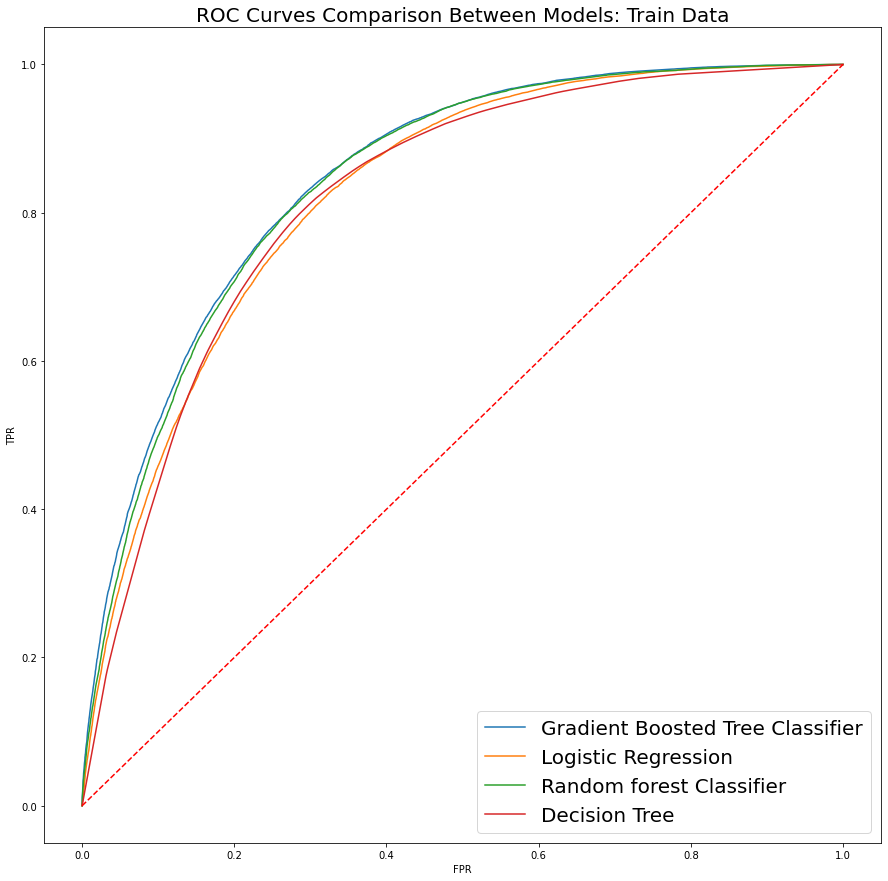

In [20]:
args = [
    [best_gbt_model, best_gbt_predictions_train, 'label', 'Gradient Boosted Tree Classifier', 'tree'],
    [best_lr_model, best_lr_preds_train, 'label', 'Logistic Regression', 'lr'],
    [best_rf_model, best_rf_predictions_train, 'label', 'Random forest Classifier', 'tree'],
    [best_dtree_model, best_dtree_predictions_train, 'label', 'Decision Tree', 'tree']
]
plot_roc(args, title=f'ROC Curves Comparison Between Models: Train Data')

##### ROC Curves of Test Data

Creating plot for: Gradient Boosted Tree Classifier


Creating plot for: Logistic Regression


Creating plot for: Random forest Classifier


Creating plot for: Decision Tree


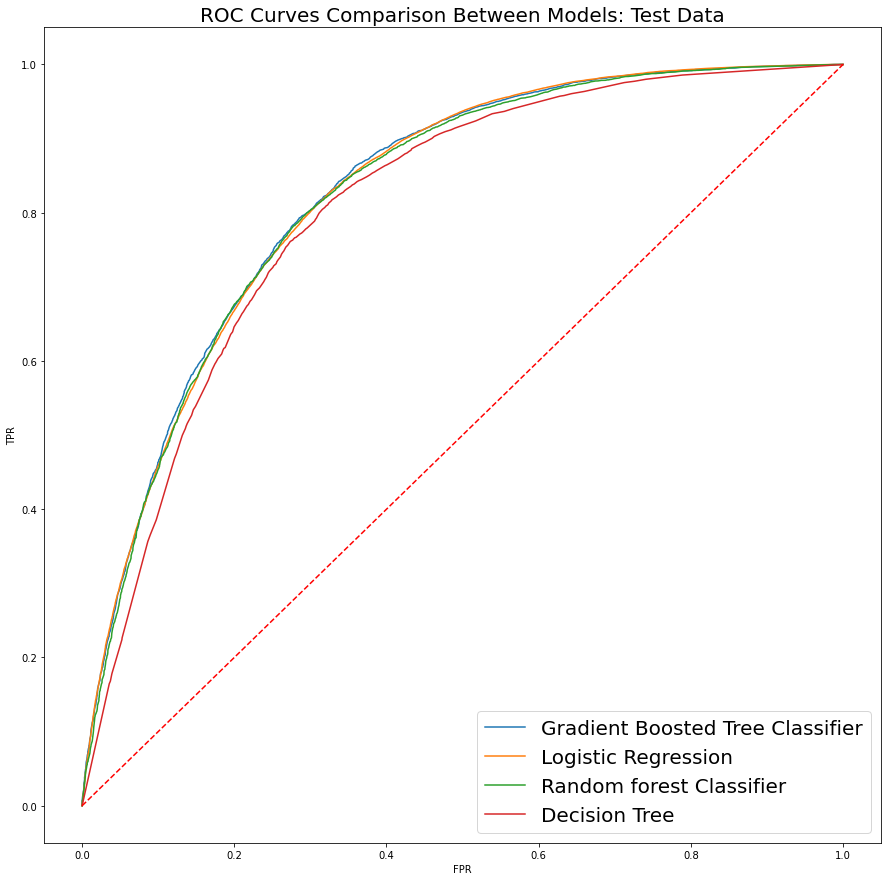

In [21]:
args = [
    [best_gbt_model, best_gbt_predictions_test, 'label', 'Gradient Boosted Tree Classifier', 'tree'],
    [best_lr_model, best_lr_preds_test, 'label', 'Logistic Regression', 'lr'],
    [best_rf_model, best_rf_predictions_test, 'label', 'Random forest Classifier', 'tree'],
    [best_dtree_model, best_dtree_predictions_test, 'label', 'Decision Tree', 'tree']
]
plot_roc(args, title=f'ROC Curves Comparison Between Models: Test Data')

## 5. Stop Spark Session: <a class="anchor" id="stop"></a>

In [22]:
spark.stop()